# Aula 6: <br>Classificação - Knn, Regressão Logistica, Naive Bayes.

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
Copyright (c) 2020.

Nessa aula vamos aprender sobre três métodos de classificação, isto é, o método dos k-vizinhos mais próximos (knn), regressão logística e naive Bayes. Cada um desses métodos é baseado em um diferente conceitos, tais como distância entre atributos (knn), regressão e teoria das probabilidades.

Vamos inicialmente ler os dados:

In [18]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
random.seed(42) # define the seed (important to reproduce the results)

data = pd.read_csv('data/vertebralcolumn-3C.csv', header=(0))
#data = pd.read_csv('data/winequality-red.csv', header=(0))

data = data.dropna(axis='rows') #remove NaN
# armazena os nomes das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  

nrow, ncol = data.shape
print("Matriz de atributos: Número de linhas:", nrow, " colunas: ", ncol)
attributes = list(data.columns)
data.head(10)

Matriz de atributos: Número de linhas: 310  colunas:  7


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,Hernia
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,Hernia
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,Hernia
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,Hernia
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,Hernia


Vamos construir as variáveis $X$ e $y$, sendo que o processo classificação se resume em estimar a função $f$ na relação $y = f(X) + \epsilon$, onde $\epsilon$ é o erro, que tem distribuição normal com média igual a zero e variância $\sigma^2$.

Convertemos os dados para o formato Numpy para facilitar a sua manipulação. 

In [19]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Vamos normalizar os dados, de modo a evitar o efeito da escala dos atributos.

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [21]:
print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 1.03143300e-16 -4.58414668e-17 -2.97969534e-16 -6.87622002e-17
  3.49541185e-16 -6.87622002e-17]
Desvio Padrao: [1. 1. 1. 1. 1. 1.]


Para treinar o classificador, precisamos definir o conjunto de teste e treinamento.

In [23]:
from sklearn.model_selection import train_test_split
p = 0.2 # fraction of elements in the test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p)

A partir desse conjunto de dados, podemos realizar a classificação.

## k-vizinhos

Para realizar a classificação, vamos usar a biblioteca scikit-learn (https://scikit-learn.org). É possível implementar o método usando métricas diferentes da Euclidiana, como as que podem ser vistas em: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

Vamos ajustar o modelo. Inicialmente, vamos considerar o método hold-out para selecionar o conjunto de teste e treinamento, que seleciona uma fração p de elementos para o conjunto de teste e (1-p), para treinamento. A seleção do modelo será feita mais adiante usando validação cruzada.

Relizando a classificação pelo método dos k-vizinhos:

In [24]:
from sklearn.neighbors import KNeighborsClassifier
k = 5 # numero de vizinhos
# ajusta o modelo k-vizinhos
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 

O erro na classificação pode ser quantificado pela medida de acurácia.

In [25]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7741935483870968


Notem quem o valor da acurácia depende do número de vizinhos $k$. Podemos selecionar o melhor valor de $k$ usando validação cruzada. 

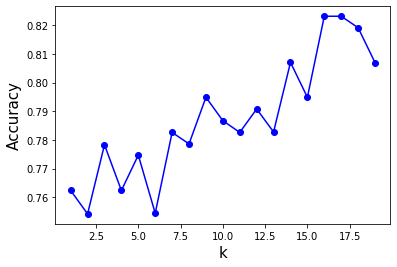

Melhor k: 16


In [26]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

nkf = 5 #number of folds
vk = [] # armazena os valores de k
vscore = []
for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    # realiza a validação cruzada
    cv = cross_validate(model, x_train, y_train, cv=nkf)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    vscore.append(cv['test_score'].mean()) 
    vk.append(k)

plt.plot(vk, vscore, '-bo')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show(True)
best_k = np.argmax(vscore)+1
print('Melhor k:', best_k)

Usando todo o conjunto de treinamento, podemos ajustar o modelo e realizar a classificação no conjunto de teste.

In [27]:
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors=best_k, metric = 'euclidean')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.7419354838709677


## Regressão logística

Realizando a classificação por regressão logística:

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Acurácia: ', model.score(x_test, y_test))

Acurácia:  0.7903225806451613


## Naive Bayes

No classificador Naive Bayes, podemos assumir que os atributos são independentes.

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy: ', model.score(x_test, y_test))

Accuracy:  0.7903225806451613


## Região de decisão

Selecionando dois atributos, podemos visualizar a região de decisão. Para graficar a região de separação, precisamos instalar a bibliteca mlxtend: http://rasbt.github.io/mlxtend/installation/<br>
Pode ser usado: conda install -c conda-forge mlxtend

Para o método k-vizinhos mais próximos:

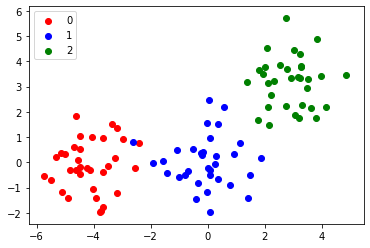

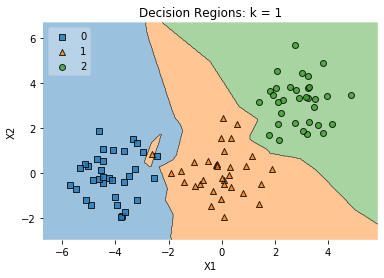

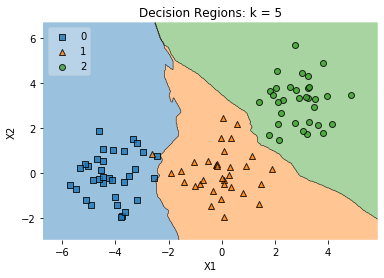

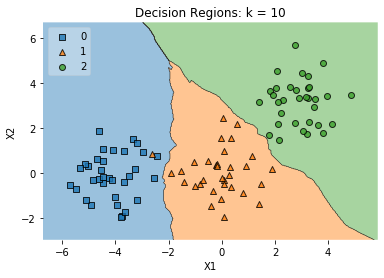

In [14]:
from mlxtend.plotting import plot_decision_regions
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
import sklearn.datasets as skdata
from matplotlib import pyplot
from pandas import DataFrame

# Gera os dados em duas dimensões
n_samples = 100 # número de observações
# centro dos grupos
centers = [(-4, 0), (0, 0), (3, 3)]
X, y = skdata.make_blobs(n_samples=100, n_features=2, cluster_std=1.0, centers=centers, 
                         shuffle=False, random_state=42)

# monta a matrix de atributos
d = np.column_stack((X,np.transpose(y)))
# converte para o formato dataframe do Pandas
data = DataFrame(data = d, columns=['X1', 'X2', 'y'])
features_names = ['X1', 'X2']
class_labels = np.unique(y)

# mostra os dados e colori de acordo com as classes
colors = ['red', 'blue', 'green', 'black']
aux = 0
for c in class_labels:
    ind = np.where(y == c)
    plt.scatter(X[ind,0][0], X[ind,1][0], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.show()

# mostra as regiões de separação para diversos valores de k
vk = [1,5,10]
for k in vk:
    # Training a classifier
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    model.fit(X, y)
    # Plotting decision regions
    plot_decision_regions(X, y, clf=model, legend=2)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Regions: k = '+str(k))
    plt.show()

Para o classificador regressão logística:

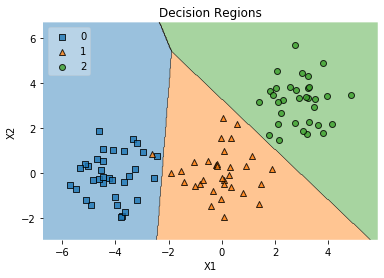

In [15]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# Training a classifier
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X, y)
# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions')
plt.show()

Notem que as curvas de separação são retas.

Para o classificador Naive Bayes:

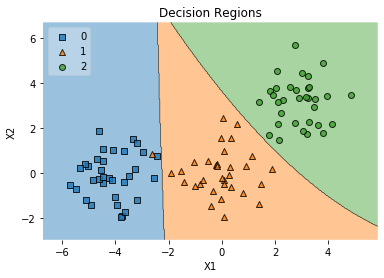

In [16]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

# Training a classifier
model = GaussianNB()
model.fit(X, y)

# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions')
plt.show()

Vejam que os métodos fornecem regiões de decisão diferentes.

### Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados.

1 - Repita todos os passos acima para a base de dados BreastCancer.

2 - Compare os três metodos de classificação para a base vertebralcolumn-3C.

3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Gere as regiões de separação para os métodos estudados nessa aula.

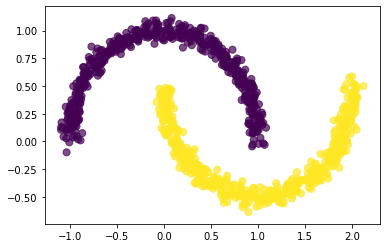

In [17]:
from sklearn import datasets
plt.figure(figsize=(6,4))

n_samples = 1000

data  = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)